In [65]:
import multiprocessing as mp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import corner

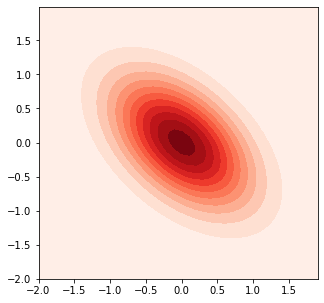

In [94]:
x, y = np.mgrid[-2:2:.1, -2:2:.01]
pos = np.dstack((x, y))
# z = sp.stats.multivariate_normal(np.array([0, 0]), np.array([[0.4, 0.2],[0.2, 0.4]])).pdf(pos)
z = sp.stats.multivariate_normal(np.array([0, 0]), np.array([[0.4, -0.2],[-0.2, 0.4]])).pdf(pos)

plt.figure(figsize=[5, 5])
plt.contourf(x, y, z, levels=14, cmap='Reds') # plot contour map of the target pdf based on values at grid points
plt.show()

In [67]:
def _MH(S, target, init, proposal_distribution, proposal_pdf, burn=0, thin=1):
  samples = []
  current = init
  accepts = 0
  for s in range(S):
      proposal = proposal_distribution(current)
      U = np.random.uniform(0, 1)
      
      if U < np.min((1, np.exp(np.log(target(proposal)) + np.log(proposal_pdf(current, proposal)) - np.log(target(current)) - np.log(proposal_pdf(proposal, current))))):
          samples.append(proposal)
          current = proposal
          accepts += 1
      else:
          samples.append(current)
  return np.array(samples)[int(burn * S)::thin], np.array(accepts) * 1. / S

In [68]:
def MH(S, target, init, proposal_distribution, proposal_pdf, burn=0, thin=1, chains=1, n_workers=1):
    with mp.Pool(processes=n_workers) as pool:
        results = [
            pool.apply_async(_MH, (S, target, init, proposal_distribution, proposal_pdf, burn, thin))
            for _ in range(chains)
        ]
        results = [result.get() for result in results]
    return list(zip(*results))

In [89]:
mu = [120, 4] # mean of the multivariate Gaussian
Sigma = 10*np.ones((2, 2)) + 1*np.eye(2) # covariance matrix of the multivariate Gaussian
# target = lambda x: sp.stats.multivariate_normal(mu, Sigma**0.5).pdf(x)
def target(x):
    return sp.stats.multivariate_normal(mu, Sigma**0.5).pdf(x)

#define the proposal distribution variance
# proposal_sigma_sq = np.array([[0.4, 0.2],[0.2, 0.4]])
proposal_sigma_sq = 2*np.eye(2)

#define the proposal distribution sampler
# proposal_distribution = lambda mean: sp.stats.multivariate_normal.rvs(mean, proposal_sigma_sq**0.5, size=1)
def proposal_distribution(mean): 
    return sp.stats.multivariate_normal.rvs(mean, proposal_sigma_sq**0.5, size=1)

#define the proposal distribution pdf
# proposal_pdf = lambda x, mean: sp.stats.multivariate_normal(mean, proposal_sigma_sq**0.5).pdf(x)
def proposal_pdf(x, mean): 
    return sp.stats.multivariate_normal(mean, proposal_sigma_sq**0.5).pdf(x)

S=100_000
init = [115,10]
#run sampler 2 on target distribution 1
chain1, ar1 = _MH(S, target, init, proposal_distribution, proposal_pdf, burn=0.2, thin=20)
chain2, ar2 = _MH(S, target, init, proposal_distribution, proposal_pdf, burn=0.2, thin=20)
chain3, ar3 = _MH(S, target, init, proposal_distribution, proposal_pdf, burn=0.2, thin=20)
samples = [chain1, chain2, chain3]
accept_rates = [ar1, ar2, ar3]

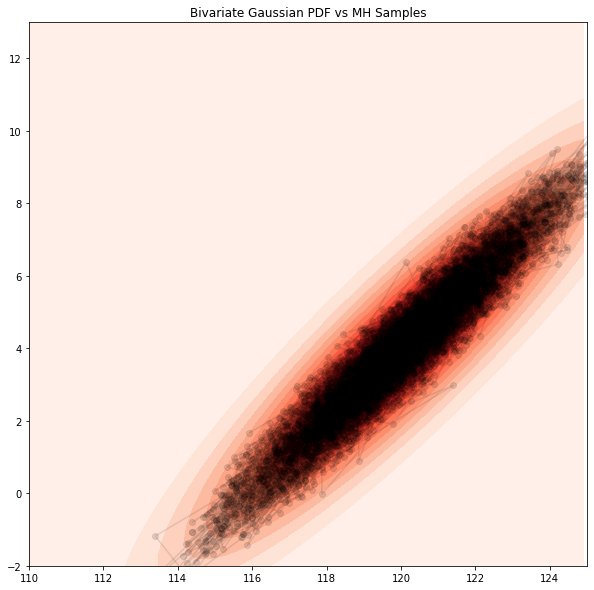

0.369


In [90]:
# Define grid points that include most of the probability mass of the pdf
# x, y = np.mgrid[samples[:, 0].min():samples[:, 0].max():.1, samples[:, 1].min():samples[:, 1].max():.01]
x, y = np.mgrid[110:125:.1, -2:13:.01]
pos = np.dstack((x, y))
# Get the value of the pdf at these grid points
z = sp.stats.multivariate_normal(mu, Sigma).pdf(pos)

# Plot the target density against samples
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.contourf(x, y, z, levels=14, cmap='Reds') # plot contour map of the target pdf based on values at grid points
for chain in samples:
    ax.scatter(chain[:, 0], chain[:, 1], color='black', alpha=0.1) # scatter plot the samples from the sampler
    ax.plot(chain[:, 0], chain[:, 1], color='black', alpha=0.1) # draw lines connecting consecutive samples

ax.set_title('Bivariate Gaussian PDF vs MH Samples') # set title
# ax.set_xlim([samples[:, 0].min(), samples[:, 0].max()])
# ax.set_ylim([samples[:, 1].min(), samples[:, 1].max()])
ax.set_xlim(110, 125)
ax.set_ylim(-2, 13)
plt.show() # display the figure

print(accept_rate)

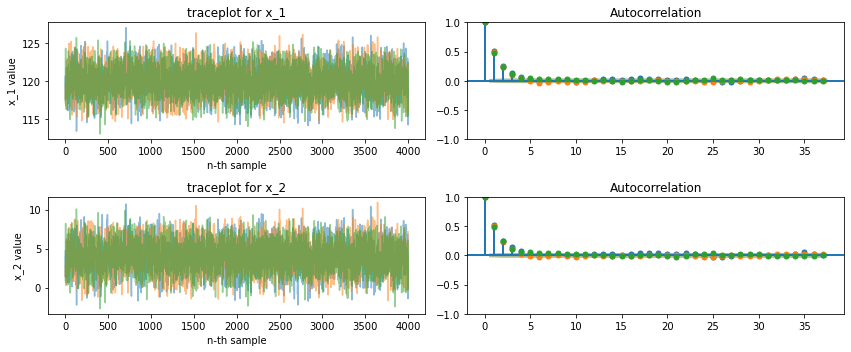

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5))
for chain in samples: 
    ax[0, 0].plot(np.arange(chain.shape[0]), chain[:, 0], alpha=0.5) # plot the trace plot for x_1
    ax[0, 0].set_xlabel('n-th sample') # set x-axis label
    ax[0, 0].set_ylabel('x_1 value') # set y-axis label
    ax[0, 0].set_title('traceplot for x_1') # set the title

    ax[1, 0].plot(np.arange(chain.shape[0]), chain[:, 1], alpha=0.5) # plot the trace plot for x_2
    ax[1, 0].set_xlabel('n-th sample') # set x-axis label
    ax[1, 0].set_ylabel('x_2 value') # set y-axis label
    ax[1, 0].set_title('traceplot for x_2') # set the title

    plot_acf(chain[:, 0], ax=ax[0, 1])
    plot_acf(chain[:, 1], ax=ax[1, 1])

plt.tight_layout() # layout the subplots nicely
plt.show() # display the figure

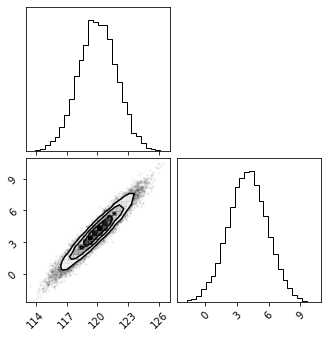

In [92]:
corner.corner(np.vstack(samples), bins=30)
plt.show()

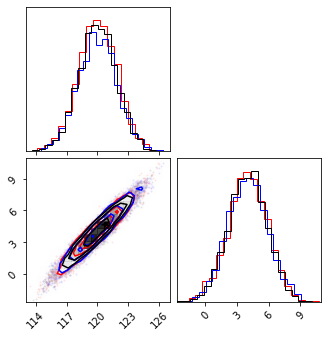

In [93]:
figure = corner.corner(samples[0], color="r")
corner.corner(samples[1], color="b", fig=figure)
corner.corner(samples[2], fig=figure)
plt.show()
